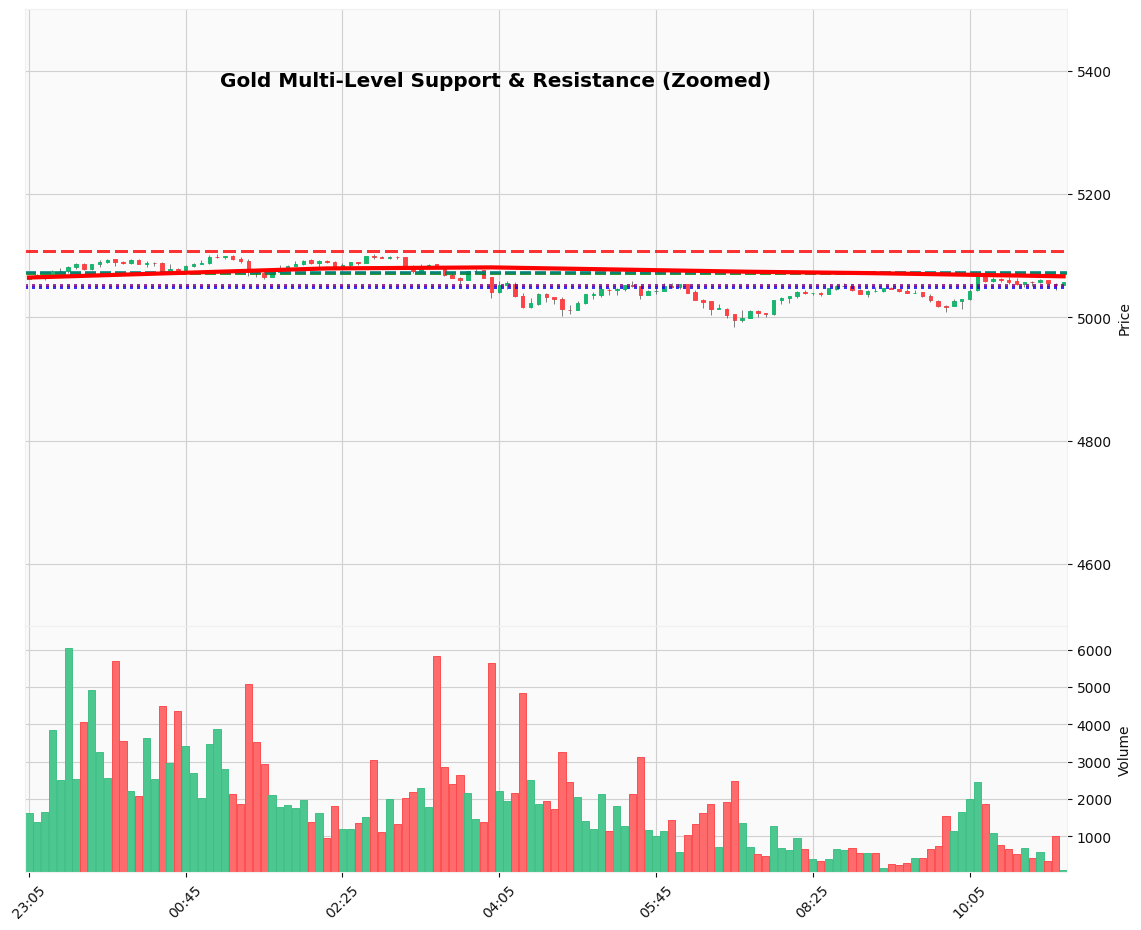

現在価格：5057.20
--- 検出された主な壁 ---
長期レジスタンス（赤）：5107.90
長期サポート（赤）：3997.40
画面周辺のサポレジ数：4本
※ 赤い線が画面外にある場合は、現在の価格から大きく離れています。


In [16]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema

# Gold (XAU/USD) データ取得
symbol = "GC=F"

df = yf.download(
    symbol,
    interval="5m",
    period="60d",
    progress=False
)

## 1. データの整理 ##
# MultiIndexの解除
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 数値への変換
for col in ["Open", "High", "Low", "Close", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 欠損値の削除とタイムゾーン（日本時間）とIndex名の変更
df.dropna(inplace=True)
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('Asia/Tokyo')
df.index.name = "Datetime"

# 全体のデータより200SMAを計算する
df['MA200'] = df['Close'].rolling(window=200).mean()

# 現在の価格
current_price = df['Close'].iloc[-1]

## サポレジ検出 ##
def get_levels(df, window=20):
    """
    局所的な高値と安値を見つける関数
    """
    levels = []
    # 高値のピーク
    highs = df['High'].values
    peaks = argrelextrema(highs, np.greater, order=window)[0]
    for p in peaks:
        levels.append((df.iloc[p]['High'], "High"))
    
    # 安値のボトム
    lows = df['Low'].values
    troughs = argrelextrema(lows, np.less, order=window)[0]
    for t in troughs:
        levels.append((df.iloc[t]['Low'], "Low"))
    
    return levels

# レベルを検出
raw_levels = get_levels(df, window=30) 

# 近すぎるレベルを整理
levels = []
raw_levels.sort(key=lambda x: x[0]) 

if raw_levels:
    current_group = [raw_levels[0][0]]
    for i in range(1, len(raw_levels)):
        price = raw_levels[i][0]
        if price - current_group[-1] < 1.0: 
            current_group.append(price)
        else:
            levels.append(np.mean(current_group))
            current_group = [price]
    levels.append(np.mean(current_group))

# --- 表示用データの作成 ---
# 直近4時間を表示
plot_start = df.index[-1] - timedelta(hours=12)
df_plot = df[df.index >= plot_start].copy()

# 計算済みMA200を持ってくる
ma200_plot = df.loc[df_plot.index, 'MA200']

# --- 線の設定 ---
hlines_levels = []
hlines_colors = []
hlines_styles = []
hlines_widths = []

# 1. 長期の壁（計算はするが、描画で見えるかどうかはカメラ次第）
long_high = df['High'].max()
long_low = df['Low'].min()

# 長期高値
hlines_levels.append(long_high)
hlines_colors.append('red')
hlines_styles.append('--')
hlines_widths.append(2.5)

# 長期安値
hlines_levels.append(long_low)
hlines_colors.append('red')
hlines_styles.append(':')
hlines_widths.append(2.5)

# 2. 自動検出した中間の壁
nearby_levels = [lvl for lvl in levels if abs(lvl - current_price) < 30] # 範囲を少し広げました（±30ドル）

# 色のパレット
colors = ['blue', 'purple', 'green', 'teal', 'magenta']

for i, level in enumerate(nearby_levels):
    # 長期の壁と重複するならスキップ
    # if abs(level - long_high) < 1.0 or abs(level - long_low) < 1.0:
    #     continue

    hlines_levels.append(level)
    hlines_widths.append(2.0)

    color = colors[i % len(colors)]
    hlines_colors.append(color)

    if level > current_price:
        hlines_styles.append('--')
    else: 
        hlines_styles.append(':')
    
## プロット設定 ##
if df_plot.empty:
    print("データがありません")
else:

    # --- ★ここを修正：カメラのズーム設定 ---
    # ローソク足の高安を取得
    view_high = df_plot['High'].max()
    view_low = df_plot['Low'].min()
    
    # 画面の縦幅（価格差）を計算
    price_range = view_high - view_low
    
    # 上下に持たせる余裕（最低でも5ドル、または画面の30%）
    # これにより、遠くの線に引っ張られず、ローソク足が見やすいサイズに保たれます
    padding = max(5.0, price_range * 0.3)

    y_limit_top = view_high + padding
    y_limit_bottom = view_low - padding
    
    # ------------------------------------

    # 200MA設定
    ap = [mpf.make_addplot(ma200_plot, color='red', width=3)]

    mpf.plot(
        df_plot,
        type="candle",
        volume=True,
        style="yahoo",
        title="Gold Multi-Level Support & Resistance (Zoomed)",
        addplot=ap,
        # 線はすべて渡すが、範囲外のものはmpfが勝手にカットしてくれる
        hlines=dict(hlines=hlines_levels, colors=hlines_colors, linestyle=hlines_styles, linewidths=hlines_widths, alpha=0.8),
        # 計算した「ローソク足中心」の範囲を適用
        # ylim=(y_limit_bottom, y_limit_top),
        ylim=(4500, 5500),
        datetime_format="%H:%M",
        figsize=(12, 10),
        tight_layout=True
    )

    print(f"現在価格：{current_price:.2f}")
    print("--- 検出された主な壁 ---")
    print(f"長期レジスタンス（赤）：{long_high:.2f}")
    print(f"長期サポート（赤）：{long_low:.2f}")
    print(f"画面周辺のサポレジ数：{len(nearby_levels)}本")
    print("※ 赤い線が画面外にある場合は、現在の価格から大きく離れています。")

In [ ]:
class GoldChartGenerator:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="60d", interval="5m"):
        """データの取得期間と足を指定してデータの取得"""
        df = yf.download(
            self.symbol,
            interval=interval,
            period=period,
            progress=False
        )

        # MultiIndexの解除
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        for col in ["Open", "High", "Low", "Close", "Volume"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        df.dropna(inplace=True)

        # タイムゾーン処理
        if df.index.tz is None:
            df.index = df.index.tz_localize('UTC')
        df.index = df.index.tz_convert('Asia/Tokyo')
        df.index.name = "Datetime"

        # 200SMA計算
        df['MA200'] = df['Close'].rolling(window=200).mean()
        self.df = df
        return self.df
    
    def _get_levels(self, df, window=30):
        """局所的な高値を見つける内部関数"""
        levels = []

        highs = df['High'].values
        peaks = argrelextrema(highs, np.greater, order=window)[0]
        for p in peaks:
            levels.append((df.iloc[p]['High'], "High"))

        lows = df['Low'].values
        troughs = argrelextrema(lows, np.less, order=window)[0]
        for t in troughs:
            levels.append((df.iloc[t]['Low'], "Low"))
        return levels
    
    def generate_chart(self, display_hours=12, y_range=30, figsize=(12, 10), save_path=None):
        """チャートの生成と表示"""
        if self.df is None:
            print("先に fetch_data を実行してください")
            return
        
        # --- 表示用データ ---
        plot_start = self.df.index[-1] - timedelta(hours=display_hours)
        df_plot = self.df[self.df.index >= plot_start].copy()

        if df_plot.empty:
            print("表示期間内のデータがありません")
            return
        
        current_price = self.df['Close'].iloc[-1]
        ma200_plot = self.df.loc[df_plot.index, 'MA200']

        # ---サポレジ検出と整理 ---
        raw_levels = self._get_levels(self.df)
        raw_levels.sort(key=lambda x: x[0])

        levels = []
        if raw_levels:
            current_group = [raw_levels[0][0]]
            for i in range(1, len(raw_levels)):
                price = raw_levels[i][0]
                if price - current_group[-1] < 1.0:
                    current_group.append(price)
                else:
                    levels.append(np.mean(current_group))
                    current_group = [price]
            levels.append(np.mean(current_group))

        
        # --- 線の設定 ---
        hlines_levels, hlines_colors, hlines_styles, hlines_widths = [], [], [], []

        # 長期の壁
        long_high, long_low = self.df['High'].max(), self.df['Low'].min()
        for val, style in [(long_high, '-'), (long_low, ':')]:
            hlines_levels.append(val)
            hlines_colors.append('red')
            hlines_styles.append(style)
            hlines_widths.append(2.5)
        
        # サポレジ
        nearby_levels = [lvl for lvl in levels if abs(lvl - current_price) < y_range]
        colors = ['blue', 'purple', 'green', 'teal', 'magenta']
        for i, level in enumerate(nearby_levels):
            hlines_levels.append(level)
            hlines_colors.append(colors[i % len(colors)])
            hlines_styles.append('--' if level > current_price else ':')
            hlines_widths.append(2.0)
        
        # --- ズーム設定 ---
        view_high, view_low = df_plot['High'].max(), df_plot['Low'].min()
        price_diff = view_high - view_low
        padding = max(5.0, price_diff * 0.3)

        y_limit_bottom = view_low - padding
        y_limit_top = view_high + padding

        # --- プロット実行 ---
        ap = [mpf.make_addplot(ma200_plot, color = 'red', width=2)]

        mpf.plot(
            df_plot,
            type="candle",
            volume=True,
            style="yahoo",
            title="Gold Multi-Level Support & Resistance",
            addplot=ap,
            hlines=dict(hlines=hlines_levels, colors=hlines_colors, linestyle=hlines_styles, linewidths=hlines_widths, alpha=0.8),
            ylim=(y_limit_bottom, y_limit_top),
            datetime_format="%H:%M",
            figsize=figsize,
            tight_layout=True,
            savefig=save_path
        )

        print(f"現在価格: {current_price:.2f} | 表示範囲: {y_limit_bottom:.2f} 〜 {y_limit_top:.2f}")



In [27]:
generator = GoldChartGenerator()

# 1. データの取得 (期間, 足の長さ)
generator.fetch_data(period="60d", interval="1h")

# 2. チャートの生成 (表示時間, サポレジを探す範囲, 画像サイズ)
generator.generate_chart(display_hours=6, y_range=20, figsize=(14, 20))

TypeError: kwarg "savefig" validator returned False for value: "None"
    'Validator'   : lambda value: isinstance(value,dict) or isinstance(value,str) or isinstance(value, io.BytesIO) or isinstance(value, os.PathLike) },